Dataset shape: (2000, 17)
   absence_days  weekly_self_study_hours  math_score  history_score  \
0             3                       27          73             81   
1             2                       47          90             86   
2             9                       13          81             97   
3             5                        3          71             74   
4             5                       10          84             77   

   physics_score  chemistry_score  biology_score  english_score  \
0             93               97             63             80   
1             96              100             90             88   
2             95               96             65             77   
3             88               80             89             63   
4             65               65             80             74   

   geography_score  career_aspiration_Business Owner  \
0               87                               0.0   
1               90              

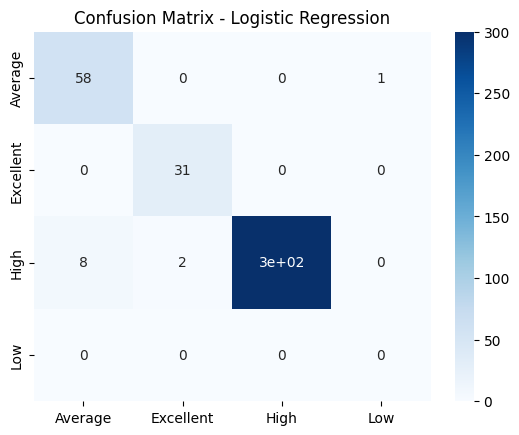


--- XGBoost Skipped: 'high_risk' column not found in dataset. ---


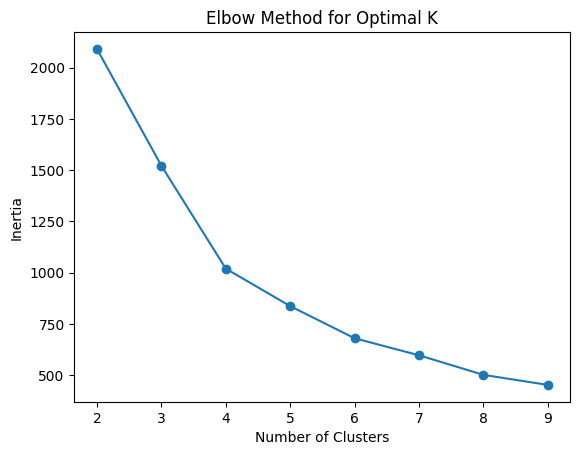


--- K-Means Demographic Clusters ---
         engagement_score  average_score
Cluster                                 
0                    23.5      82.000000
1                    34.0      86.285714
2                     0.5      77.142857


In [11]:
# STUDENT PERFORMANCE ANALYSIS
# Logistic Regression | XGBoost | K-Means Clustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE # Added SMOTE

# 1. Load Data
FILE = r"C:\Data\student_scores_selected_features.csv"
df = pd.read_csv(FILE)

print("Dataset shape:", df.shape)
print(df.head())

# ----------------------------------------------------
## 2. Logistic Regression (Performance Categories) 🎯
# ----------------------------------------------------

target = 'performance_category'
X = df.drop(columns=[target])
y = df[target]

# Separate feature types for robust preprocessing
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Define Preprocessing Pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("\ny_train class counts BEFORE SMOTE (Encoded):")
print(pd.Series(y_train).value_counts()) 

# Apply preprocessing to training and test data
X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

# **FIX:** Apply SMOTE on the transformed training data
# Set k_neighbors=1 to prevent ValueError if minority class size is 2
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train_t, y_train)

print("\ny_train class counts AFTER SMOTE (Encoded):")
print(pd.Series(y_train_res).value_counts()) 

# Logistic Regression model with fixes for imbalanced data/warnings
log_reg = LogisticRegression(
    max_iter=2000,           # Increased max_iter for convergence
    class_weight='balanced', # Added to mitigate UndefinedMetricWarning
    n_jobs=-1
)
log_reg.fit(X_train_res, y_train_res)
y_pred = log_reg.predict(X_test_t)

print("\n--- Logistic Regression Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
# Use zero_division=0 to suppress the warning text and correctly report 0.0 metrics
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ------------------------------------------------------
## 3. XGBoost (High-Risk Classification) 🚀
# ------------------------------------------------------
# Note: XGBoost is generally robust to unscaled data and imbalanced classes 
# (via scale_pos_weight), but we will preprocess here for consistency.

if 'high_risk' in df.columns:
    X2 = df.drop(columns=['high_risk'])
    y2 = df['high_risk']

    # Preprocess X2 using the same ColumnTransformer setup
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X2, y2, test_size=0.2, random_state=42, stratify=y2
    )

    X_train_t2 = preprocessor.fit_transform(X_train2)
    X_test_t2 = preprocessor.transform(X_test2)

    model_xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )

    # Grid Search for tuning
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200]
    }

    # GridSearchCV will handle the cross-validation and fitting
    grid_xgb = GridSearchCV(model_xgb, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid_xgb.fit(X_train_t2, y_train2)

    best_xgb = grid_xgb.best_estimator_
    y_pred2 = best_xgb.predict(X_test_t2)

    print("\n--- XGBoost Results (High-Risk Detection) ---")
    print("Best Params:", grid_xgb.best_params_)
    print("Accuracy:", accuracy_score(y_test2, y_pred2))
    print(classification_report(y_test2, y_pred2, zero_division=0))
else:
    print("\n--- XGBoost Skipped: 'high_risk' column not found in dataset. ---")

# ------------------------------------------------------
## 4. K-Means (Trends Across Demographics) 🌐
# ------------------------------------------------------
# K-Means section remains largely the same, using the original DataFrame (df)

# Select demographic columns (change based on your dataset)
demo_cols = [col for col in df.columns if 'gender' in col.lower() or 'age' in col.lower() or 'parent' in col.lower()]
demo_data = df[demo_cols]

# Convert categorical demographics to numeric
demo_data_encoded = pd.get_dummies(demo_data, drop_first=True)

# Scale
scaler_demo = StandardScaler()
demo_scaled = scaler_demo.fit_transform(demo_data_encoded)

# Find optimal K
inertias = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(demo_scaled)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show() # 

# Fit K-Means with chosen K (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(demo_scaled)

df['Cluster'] = clusters
print("\n--- K-Means Demographic Clusters ---")
# Aggregate to find the most frequent demographic in each cluster
print(df.groupby('Cluster')[demo_cols].agg(lambda x: x.value_counts().index[0]))

Data shape: (2000, 17)
Class distribution before SMOTE:
 performance_category
High         1240
Average       236
Excellent     122
Low             2
Name: count, dtype: int64

Accuracy: 0.9725
              precision    recall  f1-score   support

     Average       0.88      0.98      0.93        59
   Excellent       0.94      1.00      0.97        31
        High       1.00      0.97      0.98       310
         Low       0.00      0.00      0.00         0

    accuracy                           0.97       400
   macro avg       0.70      0.74      0.72       400
weighted avg       0.98      0.97      0.97       400



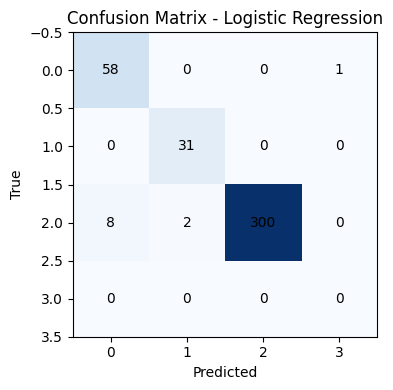

In [10]:
# logistic_regression_student_performance.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# 1. Load data
FILE = r"C:\Data\student_scores_selected_features.csv"
df = pd.read_csv(FILE)
print("Data shape:", df.shape)

# 2. Define target
target = "performance_category"  # change if needed
X = df.drop(columns=[target])
y = df[target]

# 3. Preprocessing
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Transform + balance
X_train_t = pre.fit_transform(X_train)
X_test_t = pre.transform(X_test)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())

# Use SMOTE with lower k_neighbors to avoid error
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_t, y_train = sm.fit_resample(X_train_t, y_train)

# 6. Logistic Regression
model = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
model.fit(X_train_t, y_train)
y_pred = model.predict(X_test_t)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# 7. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()



--- 1. Logistic Regression Results (Performance Categories) ---
Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

     Average       0.88      0.98      0.93        59
   Excellent       0.94      1.00      0.97        31
        High       1.00      0.97      0.98       310
         Low       0.00      0.00      0.00         0

    accuracy                           0.97       400
   macro avg       0.70      0.74      0.72       400
weighted avg       0.98      0.97      0.97       400



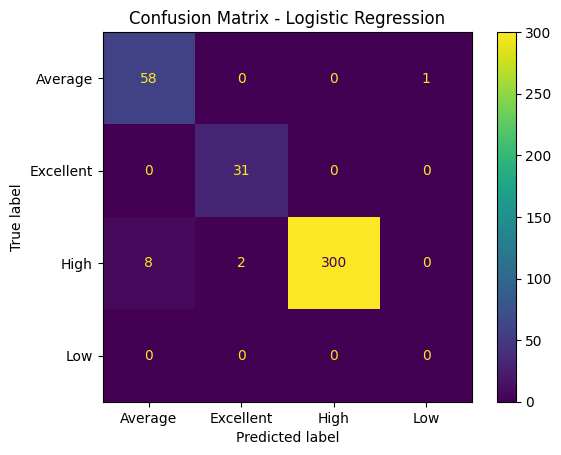

In [17]:
# LOGISTIC REGRESSION FOR PERFORMANCE CATEGORY
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE # Used for minority class oversampling

FILE = r"C:\Data\student_scores_selected_features.csv"
df = pd.read_csv(FILE)

# --- Define Target and Features ---
target = 'performance_category'
X = df.drop(columns=[target])
y = df[target]

# Encode target labels (required for classification_report compatibility)
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# Separate feature types
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# --- Preprocessing Pipeline ---
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocessor = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

# --- Split and Transform ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

# --- Imbalance Handling (SMOTE) ---
# Use k_neighbors=1 to prevent ValueError if the smallest class has size 2
sm = SMOTE(random_state=42, k_neighbors=1) 
X_train_res, y_train_res = sm.fit_resample(X_train_t, y_train)

# --- Model Training and Evaluation ---
log_reg = LogisticRegression(
    max_iter=2000, 
    class_weight='balanced', # Helps model predict minority classes
    n_jobs=-1
)
log_reg.fit(X_train_res, y_train_res)
y_pred = log_reg.predict(X_test_t)

print("\n--- 1. Logistic Regression Results (Performance Categories) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.show() #

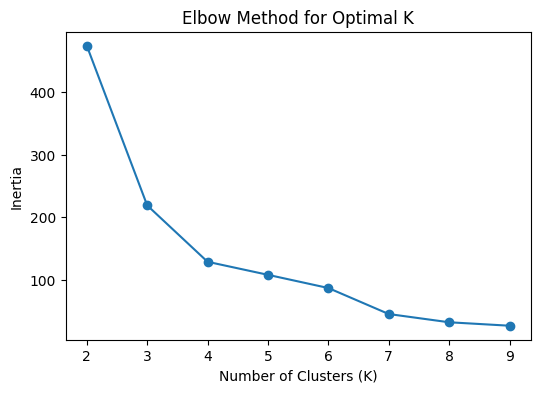


--- 3. K-Means Demographic Clusters (K=3) ---
Identifying the most frequent category in each demographic column per cluster:
         weekly_self_study_hours
Cluster                         
0                      17.713826
1                       3.705185
2                      31.283073


In [7]:
# K-MEANS FOR DEMOGRAPHIC TREND ANALYSIS
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

FILE = r"C:\Data\student_scores_selected_features.csv"
df = pd.read_csv(FILE)

# Feature Selection: Choose columns relevant for segmentation
# Adjust these columns based on the actual demographics in your file
demo_cols = [col for col in df.columns if 'gender' in col.lower() or 'parent' in col.lower() or 'study_hours' in col.lower()]
demo_data = df[demo_cols]

# Preprocessing 
# Convert categorical demographics to numeric using one-hot encoding
demo_data_encoded = pd.get_dummies(demo_data, drop_first=True)
scaler_demo = StandardScaler()
demo_scaled = scaler_demo.fit_transform(demo_data_encoded)

# Find Optimal K using Elbow Method 
inertias = []
K = range(2, 10)
for k in K:
    # Set n_init='auto' to silence warnings in newer sklearn versions
    km = KMeans(n_clusters=k, random_state=42, n_init='auto') 
    km.fit(demo_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show() # 

# Fit K-Means with Chosen K 
K_OPTIMAL = 3 
kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(demo_scaled)

df['Cluster'] = clusters

# Analysis of Clusters 
print(f"\n--- 3. K-Means Demographic Clusters (K={K_OPTIMAL}) ---")
print("Identifying the most frequent category in each demographic column per cluster:")
# The most frequent non-numeric column in each cluster is used for interpretation
cluster_summary = df.groupby('Cluster')[demo_cols].agg(lambda x: x.value_counts().index[0] if x.dtype == 'object' else x.mean())
print(cluster_summary)

Loaded: C:\Data\student_scores_selected_features.csv  shape=(2000, 17)
Demographic columns: ['engagement_score', 'average_score']


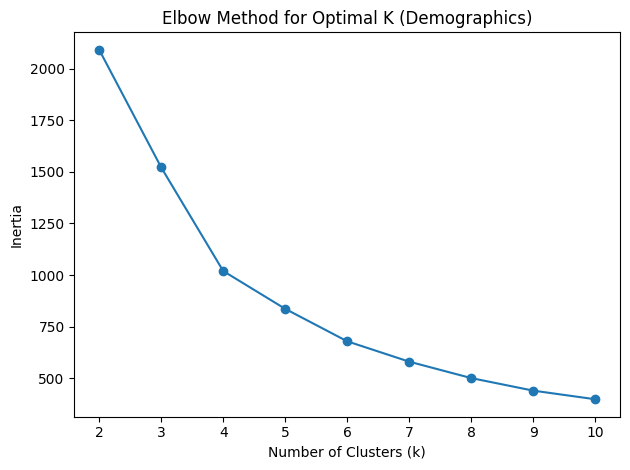


Cluster profiles:
          engagement_score  average_score
Cluster                                 
0                3.447473      77.221884
1               28.486784      88.697923
2               23.123426      80.127204


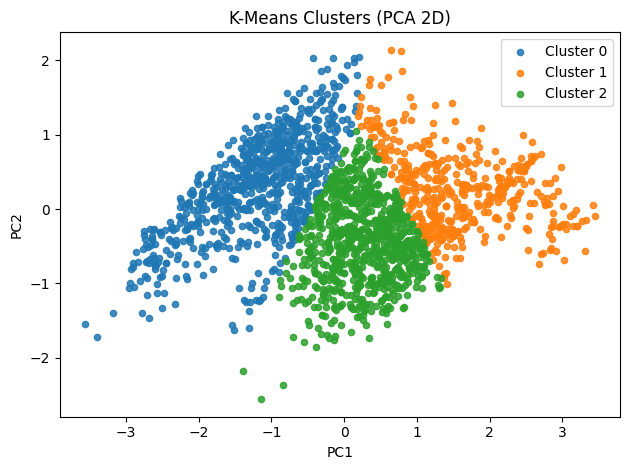

In [6]:
# kmeans_trends_demographics 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def find_demographic_columns(df):
    keys = ["gender", "age", "parent", "guardian", "ethnic", "race", "socio", "income", "education", "region", "state"]
    demo = [c for c in df.columns if any(k in c.lower() for k in keys)]
    if not demo:
        # Fallback: low-cardinality object columns (<=10 unique)
        demo = [c for c in df.columns if df[c].dtype == "object" and df[c].nunique() <= 10]
    return demo

def mode_or_top(x):
    try:
        return x.value_counts().index[0]
    except Exception:
        return np.nan

def run_kmeans(csv=r"C:\Data\student_scores_selected_features.csv",
               k=3, demo_cols=None, random_state=42):
    df = pd.read_csv(csv)
    print(f"Loaded: {csv}  shape={df.shape}")

    if demo_cols is None:
        demo_cols = find_demographic_columns(df)
    else:
        demo_cols = [c for c in demo_cols if c in df.columns]

    if not demo_cols:
        raise ValueError("Could not detect demographic columns. Provide demo_cols=['gender', 'age', ...].")

    print(f"Demographic columns: {demo_cols}")

    demo_df = df[demo_cols].copy()

    # Identify types
    numeric_cols = demo_df.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in demo_df.columns if c not in numeric_cols]

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ])

    demo_t = pre.fit_transform(demo_df)

    # Elbow method (2..10)
    inertias = []
    Ks = range(2, 11)
    for kk in Ks:
        km = KMeans(n_clusters=kk, random_state=random_state, n_init=10)
        km.fit(demo_t)
        inertias.append(km.inertia_)

    plt.figure()
    plt.plot(list(Ks), inertias, marker="o")
    plt.title("Elbow Method for Optimal K (Demographics)")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.tight_layout(); plt.show()

    # Final KMeans
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(demo_t)

    df_out = df.copy()
    df_out["Cluster"] = clusters

    # Cluster profiles (most common category / mean for numeric)
    agg_dict = {c: mode_or_top for c in categorical_cols}
    for c in numeric_cols:
        agg_dict[c] = "mean"

    profile = df_out.groupby("Cluster")[demo_cols].agg(agg_dict)
    print("\nCluster profiles:\n", profile)

    # 2D visualization via PCA
    pca = PCA(n_components=2, random_state=random_state)
    pts = pca.fit_transform(demo_t.toarray() if hasattr(demo_t, "toarray") else demo_t)

    plt.figure()
    for kk in range(k):
        idx = clusters == kk
        plt.scatter(pts[idx, 0], pts[idx, 1], label=f"Cluster {kk}", s=20, alpha=0.85)
    plt.title("K-Means Clusters (PCA 2D)")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
    plt.tight_layout(); plt.show()

    # Optionally save outputs next to your CSV
    out_dir = os.path.dirname(csv)
    profile_csv = os.path.join(out_dir, "kmeans_demographic_profiles.csv")
    profile.to_csv(profile_csv, index=True)

run_kmeans(k=3) 


Inferred binary target: career_aspiration_Business Owner
Loaded: C:\Data\student_scores_selected_features.csv  shape=(2000, 17)
Target column: career_aspiration_Business Owner (values: [0.0, 1.0])
scale_pos_weight: 5.478 (pos_ratio=0.154)

Best threshold: 0.8322
Accuracy: 0.9825 | F1 (binary): 0.9421

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       338
           1       0.97      0.92      0.94        62

    accuracy                           0.98       400
   macro avg       0.98      0.96      0.97       400
weighted avg       0.98      0.98      0.98       400



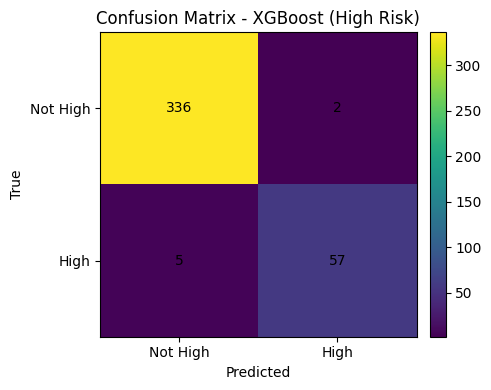

CV F1 (mean±std): 0.9113 ± 0.0294


In [4]:
# xgboost_high_risk_students 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score

try:
    from xgboost import XGBClassifier
except Exception as e:
    raise SystemExit("xgboost is required. Install with: pip install xgboost") from e

def run_xgb(csv=r"C:\Data\student_scores_selected_features.csv",
            target="high_risk", test_size=0.2, random_state=42):
    df = pd.read_csv(csv)
    if target not in df.columns:
        # Try to infer any binary column
        bin_cols = [c for c in df.columns if df[c].nunique() == 2]
        if not bin_cols:
            raise ValueError(f"Target '{target}' not found and no obvious binary column was detected.")
        target = bin_cols[0]
        print(f"Inferred binary target: {target}")

    print(f"Loaded: {csv}  shape={df.shape}")
    print(f"Target column: {target} (values: {sorted(df[target].unique())})")

    X = df.drop(columns=[target])
    y = df[target].astype(int).values

    numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train_t = pre.fit_transform(X_train)
    X_test_t  = pre.transform(X_test)

    # Class imbalance heuristic
    pos_ratio = (y_train == 1).mean()
    neg_ratio = 1 - pos_ratio
    scale_pos_weight = float(neg_ratio / max(pos_ratio, 1e-9))
    print(f"scale_pos_weight: {scale_pos_weight:.3f} (pos_ratio={pos_ratio:.3f})")

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=random_state,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1
    )
    xgb.fit(X_train_t, y_train)

    # Tune decision threshold by PR curve (maximize F1)
    proba = xgb.predict_proba(X_test_t)[:, 1]
    p, r, t = precision_recall_curve(y_test, proba)
    f1 = 2 * (p * r) / (p + r + 1e-12)
    best_idx = np.argmax(f1)
    best_t = t[best_idx] if best_idx < len(t) else 0.5
    y_pred = (proba >= best_t).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1b = f1_score(y_test, y_pred, average="binary")
    print(f"\nBest threshold: {best_t:.4f}")
    print(f"Accuracy: {acc:.4f} | F1 (binary): {f1b:.4f}\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, aspect="auto")
    ax.set_title("Confusion Matrix - XGBoost (High Risk)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_xticklabels(["Not High","High"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["Not High","High"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    # Optional: CV F1 on full pipeline
    pipe = make_pipeline(pre, XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=random_state,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1
    ))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
    print(f"CV F1 (mean±std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


run_xgb(target="high_risk")  


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1) Load data ---
df = pd.read_csv("C:\Data\student_scores_selected_features.csv")

# Separate features/labels
X = df.drop(columns=['performance_category'])
y = df['performance_category']

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# --- 2) Build a robust pipeline ---
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='lbfgs',
        max_iter=5000
    ))
])

# --- 3) Stratified CV (auto-adjust folds if smallest class is tiny) ---
class_counts = np.bincount(y_enc)
min_class = int(class_counts.min())
n_splits = max(2, min(5, min_class))  # between 2 and 5, not exceeding smallest class size

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring='accuracy')

print(f"Stratified {n_splits}-fold CV accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}  +/- {cv_scores.std():.4f}")

# --- 4) Simple holdout evaluation for a readable report ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\nHoldout set accuracy:", round(accuracy_score(y_test, y_pred), 4))

# Some small classes might be absent in the holdout split; report only present classes
present_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
present_names = le.inverse_transform(present_labels)

print("\nClassification report (holdout, present classes only):")
print(classification_report(y_test, y_pred, labels=present_labels, target_names=present_names))

print("\nConfusion matrix (rows=true, cols=pred) with present labels:")
print(confusion_matrix(y_test, y_pred, labels=present_labels))


Stratified 2-fold CV accuracy scores: [0.963 0.984]
Mean CV accuracy: 0.9735  +/- 0.0105

Holdout set accuracy: 0.988

Classification report (holdout, present classes only):
              precision    recall  f1-score   support

     Average       0.99      0.95      0.97        74
   Excellent       0.97      1.00      0.99        38
        High       0.99      0.99      0.99       388

    accuracy                           0.99       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.99      0.99      0.99       500


Confusion matrix (rows=true, cols=pred) with present labels:
[[ 70   0   4]
 [  0  38   0]
 [  1   1 386]]


Label mapping: {0: 'Average', 1: 'Excellent', 2: 'High', 3: 'Low'}

📊 Logistic Regression Report:
              precision    recall  f1-score   support

     Average     0.9483    0.9322    0.9402        59
   Excellent     0.9688    1.0000    0.9841        31
        High     0.9871    0.9871    0.9871       310
         Low     0.0000    0.0000    0.0000         0

    accuracy                         0.9800       400
   macro avg     0.7260    0.7298    0.7278       400
weighted avg     0.9799    0.9800    0.9799       400



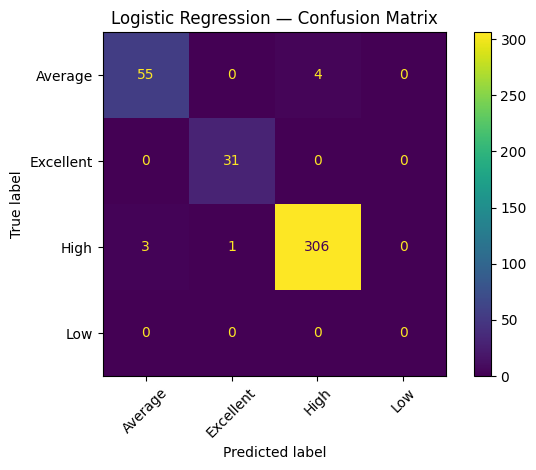

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6828 - loss: 1.2019 - val_accuracy: 0.8250 - val_loss: 0.5674
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7688 - loss: 0.6542 - val_accuracy: 0.8313 - val_loss: 0.5126
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8031 - loss: 0.5507 - val_accuracy: 0.8562 - val_loss: 0.4836
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8219 - loss: 0.4916 - val_accuracy: 0.8594 - val_loss: 0.4564
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8406 - loss: 0.4567 - val_accuracy: 0.8531 - val_loss: 0.4418
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8508 - loss: 0.4326 - val_accuracy: 0.8531 - val_loss: 0.4290
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8555 - loss: 0.4134 - val_accuracy: 0.8531 - val_loss: 0.4204
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8570 - loss: 0.3972 - val_accuracy: 0.8594 - val_loss

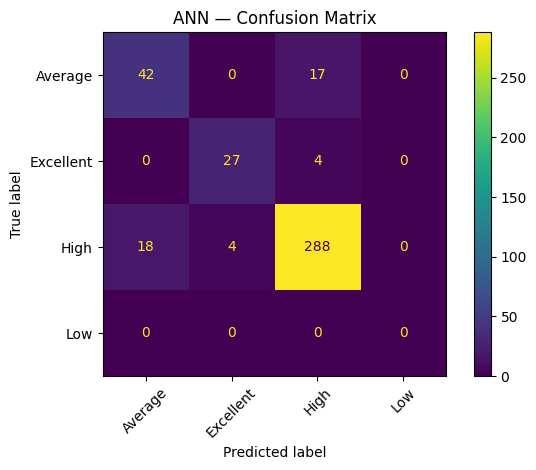

In [10]:
# student_performance_multimodel.py
# --------------------------------
# End-to-end training for Logistic Regression + ANN (sparse labels)
# with clean preprocessing, evaluation, saving (SavedModel via Keras 3 `.export()`),
# and an inference helper that reproduces preprocessing and uses tf.saved_model.load.

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# ----------------------------
# 0) Reproducibility
# ----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------------
# 1) Load data
# ----------------------------
csv_path = r"C:\Data\student_scores_selected_features.csv"
if not os.path.exists(csv_path):
    csv_path = "student_scores_selected_features.csv"

df = pd.read_csv(csv_path)

# ----------------------------
# 2) Target / features
# ----------------------------
TARGET_COL = "performance_category"  # must match your CSV exactly
if TARGET_COL not in df.columns:
    raise KeyError(f"'{TARGET_COL}' not found. Columns are: {list(df.columns)}")

y_raw = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL]).copy()

# ----------------------------
# 3) Clean + one-hot encode features
# ----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].mean(numeric_only=True))
X = pd.get_dummies(X, drop_first=True)

# ----------------------------
# 4) Encode target (0..K-1)
# ----------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)
CLASS_NAMES = le.classes_
K = len(CLASS_NAMES)
LABELS = np.arange(K)  # full label set for metrics
print("Label mapping:", dict(enumerate(CLASS_NAMES)))

# ----------------------------
# 5) Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ----------------------------
# 6) Scale features (safe for sparse matrices)
# ----------------------------
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ----------------------------
# 7) Logistic Regression
# ----------------------------
log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("\n📊 Logistic Regression Report:")
print(
    classification_report(
        y_test, y_pred_log,
        labels=LABELS,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    labels=LABELS,
    display_labels=CLASS_NAMES,
    xticks_rotation=45
)
plt.title("Logistic Regression — Confusion Matrix")
plt.tight_layout()
plt.show()

# ----------------------------
# 8) Artificial Neural Network (sparse labels)
# ----------------------------
ann_model = Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(K, activation='softmax')
])

ann_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = ann_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n🧠 ANN Test Accuracy: {acc:.4f}")

# Optional: detailed ANN report
y_pred_ann = np.argmax(ann_model.predict(X_test_scaled, verbose=0), axis=1)
print("\n📊 ANN Classification Report:")
print(
    classification_report(
        y_test, y_pred_ann,
        labels=LABELS,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_ann,
    labels=LABELS,
    display_labels=CLASS_NAMES,
    xticks_rotation=45
)
plt.title("ANN — Confusion Matrix")
plt.tight_layout()
plt.show()


In [17]:
# logistic_regression_student_performance.py
# Requires: pandas, numpy, scikit-learn

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1) Load data ---
CSV_PATH = r"C:\Data\student_scores_selected_features.csv"  # <- your file

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(
        f"Could not find the CSV at: {CSV_PATH}\n"
        "Double-check the path or file name."
    )

df = pd.read_csv(CSV_PATH)

# Expect a target column named 'performance_category'
if 'performance_category' not in df.columns:
    raise ValueError("Column 'performance_category' not found in the CSV.")

X = df.drop(columns=['performance_category'])
y = df['performance_category'].astype(str)

# --- 2) Encode labels ---
le = LabelEncoder()
y_enc = le.fit_transform(y)

# --- 3) Build pipeline: Standardize -> Logistic Regression ---
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='lbfgs',        # solid default
        max_iter=5000,         # avoids convergence warnings
        multi_class='auto',    # lets sklearn pick multinomial/ovr
        n_jobs=None            # set to -1 if you want parallelism (not needed here)
    ))
])

# --- 4) Stratified Cross-Validation (safe n_splits if smallest class is tiny) ---
class_counts = np.bincount(y_enc)
min_class = int(class_counts.min())
n_splits = max(2, min(5, min_class))  # 2..5 folds but never more than smallest class size

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_acc = cross_val_score(pipe, X, y_enc, cv=cv, scoring='accuracy')
cv_f1w = cross_val_score(pipe, X, y_enc, cv=cv, scoring='f1_weighted')

print(f"\n--- Logistic Regression: Stratified {n_splits}-fold CV ---")
print(f"Accuracy per fold : {np.round(cv_acc, 4)}")
print(f"Mean accuracy     : {cv_acc.mean():.4f}  +/- {cv_acc.std():.4f}")
print(f"Weighted F1 per fold: {np.round(cv_f1w, 4)}")
print(f"Mean weighted F1  : {cv_f1w.mean():.4f}  +/- {cv_f1w.std():.4f}")

# --- 5) Holdout split for a readable report ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

holdout_acc = accuracy_score(y_test, y_pred)
print(f"\n--- Holdout Results (25% test) ---")
print(f"Accuracy: {holdout_acc:.4f}")

# Some classes might be absent in the test fold; handle that cleanly:
present_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
present_names = le.inverse_transform(present_labels)

print("\nClassification report (present classes only):")
print(classification_report(y_test, y_pred,
                            labels=present_labels,
                            target_names=present_names))

print("Confusion matrix (rows=true, cols=pred), present labels order:")
print(present_names)
print(confusion_matrix(y_test, y_pred, labels=present_labels))

# --- 6) Quick notes ---
# Higher is better for both Accuracy and F1 (weighted).
# If you ever see warnings about convergence, you can raise max_iter further
# or keep StandardScaler (already included) to help the optimizer.



--- Logistic Regression: Stratified 2-fold CV ---
Accuracy per fold : [0.963 0.984]
Mean accuracy     : 0.9735  +/- 0.0105
Weighted F1 per fold: [0.9626 0.9834]
Mean weighted F1  : 0.9730  +/- 0.0104

--- Holdout Results (25% test) ---
Accuracy: 0.9880

Classification report (present classes only):
              precision    recall  f1-score   support

     Average       0.99      0.95      0.97        74
   Excellent       0.97      1.00      0.99        38
        High       0.99      0.99      0.99       388

    accuracy                           0.99       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.99      0.99      0.99       500

Confusion matrix (rows=true, cols=pred), present labels order:
['Average' 'Excellent' 'High']
[[ 70   0   4]
 [  0  38   0]
 [  1   1 386]]


In [3]:
# XGBoost on selected features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# --- Load ---
FILE = r"C:\Data\student_scores_selected_features.csv"
df = pd.read_csv(FILE)

# --- Column aliases to survive slight name changes ---
col_map = {
    "absence_days": ["absence_days"],
    "weekly_self_study_hours": ["weekly_self_study_hours", "weekly_study_hours"],
    "engagement_score": ["engagement_score", "engagement_scores"],
    "performance_category": ["performance_category"]
}

def pick_first_present(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    raise KeyError(f"None of {candidates} found in columns: {list(cols)}")

absence_col   = pick_first_present(col_map["absence_days"], df.columns)
study_col     = pick_first_present(col_map["weekly_self_study_hours"], df.columns)
engage_col    = pick_first_present(col_map["engagement_score"], df.columns)
target_col    = pick_first_present(col_map["performance_category"], df.columns)

features = [absence_col, study_col, engage_col]
X = df[features]
y = df[target_col].astype(str)

# --- Encode target ---
le = LabelEncoder()
y_enc = le.fit_transform(y)

# --- Impute missing numerics (XGB can handle some NaNs, but this is safer/repeatable) ---
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- XGBoost model (tuned-light, safe defaults) ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# --- Metrics (restrict report to present labels to avoid mismatch) ---
present_labels = np.unique(np.concatenate([y_test, y_pred]))
present_names = le.inverse_transform(present_labels)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report (present classes only):")
print(classification_report(y_test, y_pred,
                            labels=present_labels,
                            target_names=present_names))

print("\nConfusion Matrix (rows=true, cols=pred), order:", list(present_names))
print(confusion_matrix(y_test, y_pred, labels=present_labels))


Accuracy: 0.835

Classification Report (present classes only):
              precision    recall  f1-score   support

     Average       0.52      0.25      0.34        59
   Excellent       0.90      0.84      0.87        31
        High       0.86      0.95      0.90       310

    accuracy                           0.83       400
   macro avg       0.76      0.68      0.70       400
weighted avg       0.81      0.83      0.81       400


Confusion Matrix (rows=true, cols=pred), order: ['Average', 'Excellent', 'High']
[[ 15   0  44]
 [  0  26   5]
 [ 14   3 293]]


In [4]:
# xgb_student_performance.py
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

# --- 1) Load data ---
# Change this if you're running locally:
FILE = r"C:\Data\student_scores_selected_features.csv"

# Fallback to uploaded path (if you’re running this in a notebook where the file is uploaded)
if not os.path.exists(FILE):
    alt = "/mnt/data/student_scores_selected_features.csv"
    if os.path.exists(alt):
        FILE = alt
    else:
        raise FileNotFoundError(f"CSV not found at {FILE} (or {alt}).")

df = pd.read_csv(FILE)

# --- 2) Resolve columns (map intended names to actual CSV columns) ---
# You said you want these 3 inputs:
INTENDED = {
    "absence_days": ["absence_days"],
    "weekly_study_hours": ["weekly_study_hours", "weekly_self_study_hours"],
    "engagement_scores": ["engagement_scores", "engagement_score"],
}
TARGET = "performance_category"

def pick_existing(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

resolved = {}
for alias, candidates in INTENDED.items():
    col = pick_existing(candidates, df.columns)
    if col is None:
        raise KeyError(f"None of {candidates} found in CSV columns: {list(df.columns)}")
    resolved[alias] = col

if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found. Columns: {list(df.columns)}")

# Build X, y with actual column names
X = df[[resolved["absence_days"], resolved["weekly_study_hours"], resolved["engagement_scores"]]].copy()
y = df[TARGET].astype(str)

# Optional: basic NA handling (XGBoost can handle NaN, but you may prefer filling)
# X = X.fillna(X.median(numeric_only=True))

# --- 3) Encode target labels ---
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

# --- 4) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- 5) (Optional) per-sample weights for imbalance ---
# This gently balances classes without SMOTE.
vals, counts = np.unique(y_train, return_counts=True)
class_weights = {cls: (len(y_train) / (len(vals) * cnt)) for cls, cnt in zip(vals, counts)}
sample_weight = np.vectorize(class_weights.get)(y_train)

# --- 6) XGBoost model ---
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss"
)

xgb.fit(X_train, y_train, sample_weight=sample_weight)

# --- 7) Evaluate ---
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Restrict report to labels present in test or predictions to avoid mismatch
present_labels = np.unique(np.concatenate([y_test, y_pred]))
present_names = le.inverse_transform(present_labels)

print("\n--- XGBoost (3 features) ---")
print(f"Using columns: {resolved}")
print(f"Accuracy: {acc:.4f}")

print("\nClassification report (present classes only):")
print(classification_report(
    y_test, y_pred,
    labels=present_labels,
    target_names=present_names,
    zero_division=0
))

print("Confusion matrix (rows=true, cols=pred), order:", list(present_names))
print(confusion_matrix(y_test, y_pred, labels=present_labels))

# --- 8) Feature importances ---
importances = xgb.feature_importances_
feat_order = [resolved["absence_days"], resolved["weekly_study_hours"], resolved["engagement_scores"]]
print("\nFeature importances (gain-based):")
for name, imp in sorted(zip(feat_order, importances), key=lambda t: -t[1]):
    print(f"  {name:28s} {imp:.4f}")



--- XGBoost (3 features) ---
Using columns: {'absence_days': 'absence_days', 'weekly_study_hours': 'weekly_self_study_hours', 'engagement_scores': 'engagement_score'}
Accuracy: 0.6325

Classification report (present classes only):
              precision    recall  f1-score   support

     Average       0.28      0.58      0.38        59
   Excellent       0.44      0.87      0.58        31
        High       0.89      0.62      0.73       310
         Low       0.00      0.00      0.00         0

    accuracy                           0.63       400
   macro avg       0.40      0.52      0.42       400
weighted avg       0.76      0.63      0.67       400

Confusion matrix (rows=true, cols=pred), order: ['Average', 'Excellent', 'High', 'Low']
[[ 34   2  22   1]
 [  2  27   2   0]
 [ 84  33 192   1]
 [  0   0   0   0]]

Feature importances (gain-based):
  absence_days                 0.3624
  weekly_self_study_hours      0.3217
  engagement_score             0.3160


In [9]:
#use the cleaned data to do lo

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load CSV
df = pd.read_csv(r"C:\Data\student-scores-enhanced.csv")

# Create binary target for logistic regression (1 = high performer)
df["high_performer"] = (df["average_score"] >= 80).astype(int)

# Select features (you may refine later)
feature_cols = [
    "part_time_job",
    "absence_days",
    "extracurricular_activities",
    "weekly_self_study_hours",
    "engagement_score",
    "performance_consistency"
]

X = df[feature_cols]
y = df["high_performer"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Coefficients
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": model.coef_[0]
})
print("\nLogistic Regression Coefficients:")
print(coef_df)



Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59       166
           1       0.71      0.77      0.74       234

    accuracy                           0.68       400
   macro avg       0.67      0.66      0.66       400
weighted avg       0.68      0.68      0.68       400


Logistic Regression Coefficients:
                      Feature  Coefficient
0               part_time_job    -0.056911
1                absence_days    -0.087655
2  extracurricular_activities     0.026415
3     weekly_self_study_hours     0.276026
4            engagement_score     0.278660
5     performance_consistency     0.571350
